<a href="https://colab.research.google.com/github/Coolicc/Big-Data-Analysis-PySpark/blob/main/6th_homework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Podešavanje Sparka za rad u Google Colabu
#####Izvršite sve komande u datom redosledu

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
!java -version

openjdk version "11.0.6" 2020-01-14
OpenJDK Runtime Environment (build 11.0.6+10-post-Ubuntu-1ubuntu118.04.1)
OpenJDK 64-Bit Server VM (build 11.0.6+10-post-Ubuntu-1ubuntu118.04.1, mixed mode, sharing)


In [ ]:
!update-alternatives --config java

There are 2 choices for the alternative java (providing /usr/bin/java).

  Selection    Path                                            Priority   Status
------------------------------------------------------------
* 0            /usr/lib/jvm/java-11-openjdk-amd64/bin/java      1111      auto mode
  1            /usr/lib/jvm/java-11-openjdk-amd64/bin/java      1111      manual mode
  2            /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java   1081      manual mode

Press <enter> to keep the current choice[*], or type selection number: 


In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

In [ ]:
!pip install pyspark

     |████████████████████████████████| 217.8MB 61kB/s 
     |████████████████████████████████| 204kB 47.7MB/s 
  Created wheel for pyspark: filename=pyspark-2.4.5-py2.py3-none-any.whl size=218257927 sha256=c60194b174dd873dcb7109725f7bb3532b00851127d5a188328cf7ecc7d5947b
  Stored in directory: /root/.cache/pip/wheels/bf/db/04/61d66a5939364e756eb1c1be4ec5bdce6e04047fc7929a3c3c
Successfully built pyspark


###**Zadatak**
Sa adrese https://www.kaggle.com/c/titanic/data preuzeti fajl **train.csv**. Fajl opisuje putnike koji su bili na brodu Titanik. Naš zadatak je da odredimo da li će neka osoba preživeti ili ne brodolom koristeći algoritam mašinskog učenja.

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [ ]:
data = spark.read.csv('/content/drive/My Drive/nastava/Analiza velikih podataka/train.csv',header=True)
data.show(5)

+-----------+--------+------+--------------------+------+---+-----+-----+----------------+-------+-----+--------+
|PassengerId|Survived|Pclass|                Name|   Sex|Age|SibSp|Parch|          Ticket|   Fare|Cabin|Embarked|
+-----------+--------+------+--------------------+------+---+-----+-----+----------------+-------+-----+--------+
|          1|       0|     3|Braund, Mr. Owen ...|  male| 22|    1|    0|       A/5 21171|   7.25| null|       S|
|          2|       1|     1|Cumings, Mrs. Joh...|female| 38|    1|    0|        PC 17599|71.2833|  C85|       C|
|          3|       1|     3|Heikkinen, Miss. ...|female| 26|    0|    0|STON/O2. 3101282|  7.925| null|       S|
|          4|       1|     1|Futrelle, Mrs. Ja...|female| 35|    1|    0|          113803|   53.1| C123|       S|
|          5|       0|     3|Allen, Mr. Willia...|  male| 35|    0|    0|          373450|   8.05| null|       S|
+-----------+--------+------+--------------------+------+---+-----+-----+---------------

In [ ]:
dataForAnalysis = data.select("Sex","Age","Pclass","Survived")
dataForAnalysis.count()


891

In [ ]:
#da li imamo null vrednosti, ako da izbacićemo sve vrste koje sadrže bilo gde null
dataForAnalysis = dataForAnalysis.dropna()
dataForAnalysis.count()

714

In [ ]:
#pretvorićemo kolone u odgovarajuće tipove
from pyspark.sql.types import *

dataForAnalysis = dataForAnalysis.withColumn("Age",dataForAnalysis["Age"].cast(IntegerType())). \
                withColumn("Pclass",dataForAnalysis["Pclass"].cast(IntegerType())). \
                withColumn("Survived",dataForAnalysis["Survived"].cast(DoubleType()))

dataForAnalysis.printSchema()

root
 |-- Sex: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- Survived: double (nullable = true)



In [ ]:
#podelićemo podatke na trening i test skup
splits = dataForAnalysis.randomSplit([0.8,0.2])
train = splits[0]
test = splits[1]
print("Broj vrsta u treningu ",str(train.count()))
print("Broj vrsta u testu ",str(test.count()))

Broj vrsta u treningu  569
Broj vrsta u testu  145


In [ ]:
#kreiraćemo estimator da pretvorimo kategoricke vrednosti za pol u numeričke
from pyspark.ml.feature import StringIndexer

indexer = StringIndexer(inputCol="Sex",outputCol="SexNum")

In [ ]:
#kreiraćemo estimator da kolonu  SexNum pretvorimo u niz 0 i 1 slično kolonu Pclass
from pyspark.ml.feature import OneHotEncoderEstimator
onehot = OneHotEncoderEstimator(inputCols=["SexNum","Pclass"],outputCols=["SexVec","PclassVec"]) 

In [ ]:
#kreiramo transformer da kolone skupimo  u jedan vektor
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols=["Age","SexVec","PclassVec"],outputCol="features")

In [ ]:
#kreiramo estimator koji predstavlja algoritam mašinskog učenja
from pyspark.ml.classification import RandomForestClassifier

forest = RandomForestClassifier(featuresCol="features",labelCol="Survived")

In [ ]:
#kreiramo Pipeline
from pyspark.ml import Pipeline

pipeline = Pipeline(stages=[indexer,onehot,assembler,forest])
model = pipeline.fit(train)
prediction = model.transform(test)

In [ ]:
#evaluacija modela
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(labelCol="Survived")
print("Metrika: ",evaluator.getMetricName())
evaluator.evaluate(prediction)

Metrika:  areaUnderROC


0.8536844135802468

###Zadatak
Model pogađa sa tačnošću od 85% pri tome nismo podešavali ništa od hiperparametara, uzeli smo default vrednosti. Koristili smo RandomForest algoritam i uzeli smo samo tri kolone kao osobine atributa. Probajte da dobijete bolji rezultat, menjajući algoritam, atribute koji ulaze u analizu i konfigurisanje hiperparametara korišćenjem validatora

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [ ]:
data = spark.read.csv('/content/drive/My Drive/train.csv',header=True)
print(data.count())
data.show(5)

891
+-----------+--------+------+--------------------+------+---+-----+-----+----------------+-------+-----+--------+
|PassengerId|Survived|Pclass|                Name|   Sex|Age|SibSp|Parch|          Ticket|   Fare|Cabin|Embarked|
+-----------+--------+------+--------------------+------+---+-----+-----+----------------+-------+-----+--------+
|          1|       0|     3|Braund, Mr. Owen ...|  male| 22|    1|    0|       A/5 21171|   7.25| null|       S|
|          2|       1|     1|Cumings, Mrs. Joh...|female| 38|    1|    0|        PC 17599|71.2833|  C85|       C|
|          3|       1|     3|Heikkinen, Miss. ...|female| 26|    0|    0|STON/O2. 3101282|  7.925| null|       S|
|          4|       1|     1|Futrelle, Mrs. Ja...|female| 35|    1|    0|          113803|   53.1| C123|       S|
|          5|       0|     3|Allen, Mr. Willia...|  male| 35|    0|    0|          373450|   8.05| null|       S|
+-----------+--------+------+--------------------+------+---+-----+-----+-----------

In [ ]:
import pyspark.sql.functions as F

data.select([F.count(F.when(F.isnan(i) | F.col(i).contains('NA') | F.col(i).contains('NULL') | F.col(i).isNull(), i)).alias(i) for i in data.columns]).show()

+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+
|PassengerId|Survived|Pclass|Name|Sex|Age|SibSp|Parch|Ticket|Fare|Cabin|Embarked|
+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+
|          0|       0|     0|   0|  0|177|    0|    0|     0|   0|  687|       2|
+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+



In [ ]:
avg_age = int(data.agg(F.mean(data['Age'])).collect()[0]['avg(Age)'])
print(avg_age)
mod_embarkation = data.groupBy('Embarked').count().orderBy(F.desc('count')).collect()[0]['Embarked']
print(mod_embarkation)
data2 = data.fillna({'Age': avg_age, 'Embarked': mod_embarkation})
data3 = data2.drop('Cabin').drop('PassengerId').drop('Ticket').drop('Name')
print(data3.show(5))
data3.select([F.count(F.when(F.isnan(i) | F.col(i).contains('NA') | F.col(i).contains('NULL') | F.col(i).isNull(), i)).alias(i) for i in data3.columns]).show()

29
S
+--------+------+------+---+-----+-----+-------+--------+
|Survived|Pclass|   Sex|Age|SibSp|Parch|   Fare|Embarked|
+--------+------+------+---+-----+-----+-------+--------+
|       0|     3|  male| 22|    1|    0|   7.25|       S|
|       1|     1|female| 38|    1|    0|71.2833|       C|
|       1|     3|female| 26|    0|    0|  7.925|       S|
|       1|     1|female| 35|    1|    0|   53.1|       S|
|       0|     3|  male| 35|    0|    0|   8.05|       S|
+--------+------+------+---+-----+-----+-------+--------+
only showing top 5 rows

None
+--------+------+---+---+-----+-----+----+--------+
|Survived|Pclass|Sex|Age|SibSp|Parch|Fare|Embarked|
+--------+------+---+---+-----+-----+----+--------+
|       0|     0|  0|  0|    0|    0|   0|       0|
+--------+------+---+---+-----+-----+----+--------+



In [ ]:
from pyspark.sql.types import *
data4 = data3.withColumn("Age",data3["Age"].cast(IntegerType())). \
                withColumn("Pclass",data3["Pclass"].cast(IntegerType())). \
                withColumn("Survived",data3["Survived"].cast(DoubleType())). \
                withColumn("SibSp",data3["SibSp"].cast(IntegerType())). \
                withColumn("Parch",data3["Parch"].cast(IntegerType())). \
                withColumn("Fare",data3["Fare"].cast(DoubleType()))

In [ ]:
data4.groupBy('Pclass').avg('Survived').show()

+------+-------------------+
|Pclass|      avg(Survived)|
+------+-------------------+
|     1| 0.6296296296296297|
|     3|0.24236252545824846|
|     2|0.47282608695652173|
+------+-------------------+



In [ ]:
data4.groupBy('Sex').avg('Survived').show()

+------+-------------------+
|   Sex|      avg(Survived)|
+------+-------------------+
|female| 0.7420382165605095|
|  male|0.18890814558058924|
+------+-------------------+



In [ ]:
data4.groupBy('SibSp').avg('Survived').show()

+-----+-------------------+
|SibSp|      avg(Survived)|
+-----+-------------------+
|    1| 0.5358851674641149|
|    3|               0.25|
|    5|                0.0|
|    4|0.16666666666666666|
|    8|                0.0|
|    2| 0.4642857142857143|
|    0|0.34539473684210525|
+-----+-------------------+



In [ ]:
data4.groupBy('Parch').avg('Survived').show()

+-----+-------------------+
|Parch|      avg(Survived)|
+-----+-------------------+
|    1| 0.5508474576271186|
|    6|                0.0|
|    3|                0.6|
|    5|                0.2|
|    4|                0.0|
|    2|                0.5|
|    0|0.34365781710914456|
+-----+-------------------+



In [ ]:
data4.groupBy('Embarked').avg('Survived').show()

+--------+-------------------+
|Embarked|      avg(Survived)|
+--------+-------------------+
|       Q|0.38961038961038963|
|       C| 0.5535714285714286|
|       S|0.33900928792569657|
+--------+-------------------+



In [ ]:
data5 = data4.withColumn('FamSz', F.col('Parch') + F.col('SibSp') + 1)
data5.groupBy('FamSz').avg('Survived').show()

+-----+-------------------+
|FamSz|      avg(Survived)|
+-----+-------------------+
|    1|0.30353817504655495|
|    6|0.13636363636363635|
|    3| 0.5784313725490197|
|    5|                0.2|
|    4| 0.7241379310344828|
|    8|                0.0|
|    7| 0.3333333333333333|
|   11|                0.0|
|    2| 0.5527950310559007|
+-----+-------------------+



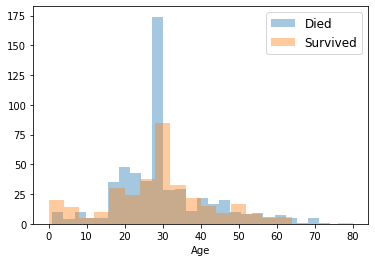

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np

hist_data = data5.select(['Age', 'Fare', 'Survived']).toPandas()
sn.distplot(hist_data[hist_data.Survived == 0]['Age'],  kde=False, label='Died')
sn.distplot(hist_data[hist_data.Survived == 1]['Age'],  kde=False, label='Survived')
plt.legend(prop={'size': 12})

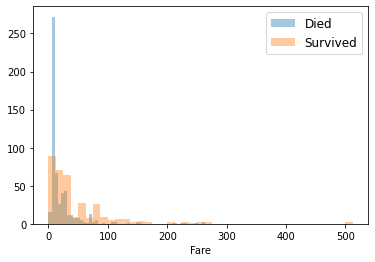

In [ ]:
sn.distplot(hist_data[hist_data.Survived == 0]['Fare'],  kde=False, label='Died')
sn.distplot(hist_data[hist_data.Survived == 1]['Fare'],  kde=False, label='Survived')
plt.legend(prop={'size': 12})

In [ ]:
splits = data5.randomSplit([0.8,0.2])
train = splits[0]
test = splits[1]

In [ ]:
from pyspark.ml.feature import StringIndexer

sex_indexer = StringIndexer(inputCol="Sex",outputCol="SexNum")
embarked_indexer = StringIndexer(inputCol="Embarked",outputCol="EmNum")

In [ ]:
from pyspark.ml.feature import OneHotEncoderEstimator

onehot = OneHotEncoderEstimator(inputCols=["SexNum","Pclass","EmNum","FamSz"],outputCols=["SexVec","PclassVec","EmVec","FamSzVec"]) 

In [ ]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols=["Age","SexVec","PclassVec","Fare","EmVec","FamSzVec"],outputCol="features")

In [ ]:
from pyspark.ml.classification import RandomForestClassifier

forest = RandomForestClassifier(featuresCol="features",labelCol="Survived")

In [ ]:
from pyspark.ml import Pipeline

pipeline = Pipeline(stages=[sex_indexer,embarked_indexer,onehot,assembler,forest])
model = pipeline.fit(train)
prediction = model.transform(test)

In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(labelCol="Survived")
print("Metrika: ",evaluator.getMetricName())
evaluator.evaluate(prediction)

Metrika:  areaUnderROC


0.895887281035796

In [ ]:
from pyspark.ml.classification import LogisticRegression

logReg = LogisticRegression(featuresCol="features", labelCol="Survived")
pipeline2 = Pipeline(stages=[sex_indexer,embarked_indexer,onehot,assembler,logReg])
model2 = pipeline2.fit(train)
prediction2 = model2.transform(test)
evaluator2 = BinaryClassificationEvaluator(labelCol="Survived")
print("Metrika: ",evaluator2.getMetricName())
evaluator2.evaluate(prediction2)

Metrika:  areaUnderROC


0.8955064737242953

In [ ]:
from pyspark.ml.tuning import ParamGridBuilder,TrainValidationSplit
from pyspark.ml.evaluation import BinaryClassificationEvaluator

paramGrid = ParamGridBuilder().addGrid(logReg.regParam,[0.0,0.2,0.5]).addGrid(logReg.maxIter,[100,200]).build()
ev = BinaryClassificationEvaluator(labelCol="Survived")
validator = TrainValidationSplit(estimator=pipeline2, estimatorParamMaps=paramGrid, evaluator=ev,collectSubModels=True)
model22 = validator.fit(train)
prediction22 = model22.transform(test)
evaluator22 = BinaryClassificationEvaluator(labelCol="Survived")
print("Metrika: ",evaluator22.getMetricName())
evaluator22.evaluate(prediction22)

Metrika:  areaUnderROC


0.8955064737242953